<h2>Get All the Things</h2>

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from keras import layers
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Import the Data</h2>

In [78]:
#X is a set of parameters defined at the point of entry for each trade.
#y is a list of returns for each trade.
X = pd.read_csv("Data/X.csv",header=None).values
y = pd.read_csv("Data/y.csv",header=None).values.reshape(-1,1)

#X = np.random.randn(8000,23)
#y = (X[:,1]*X[:,3] + 20*X[:,22]).reshape(8000,1)
print("X shape = {} :: y.shape = {}".format(X.shape,y.shape))


X shape = (8789, 23) :: y.shape = (8789, 1)


<h2>Prepare the Data</h2>

In [391]:
threshold = .5e-4
#Replicate some good trades to even out the numbers:


w = (y>threshold)
l = (y<=threshold)
Xw = X[w[:,0],:] #Weird indexing 
yw = y[w[:,0],:]
Xl = X[l[:,0],:]
yl = y[l[:,0],:]
Xe = np.concatenate((Xl,Xw,Xw,Xw),axis = 0)
ye = np.concatenate((yl,yw,yw,yw),axis = 0)



#Scale Data (lets remove this,I think it's introducing look ahead bias. Need to pre normalize)
#Shuffle?: np.random.shuffle(a)
scaler = MinMaxScaler()
scaler.fit(X)
Xs = scaler.transform(Xe)


#Downselect X data: (redice feature set)
Xsr = Xs[:,10:]


# Divide into training and test Data (Lets soon add a Validation Set as well)
X_train, X_test, y_train, y_test = train_test_split(
        Xsr, ye, random_state=0,test_size = 0.4)


# Select a threshold for the True category in y, and convert to categorical:
y_thresholded = np.zeros(y_test.shape)
for j in range(1,len(y_thresholded)):
    if y_test[j]>threshold:
        y_thresholded[j] = 1
y_test_categorical = to_categorical(y_thresholded)

y_thresholded = np.zeros(y_train.shape)
for j in range(1,len(y_thresholded)):
    if y_train[j]>threshold:
        y_thresholded[j] = 1
y_train_categorical = to_categorical(y_thresholded)

print("X_train = {} :: X_test = {} :: y_train = {} :: y_test = {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train = (7423, 13) :: X_test = (4950, 13) :: y_train = (7423, 1) :: y_test = (4950, 1)


<h2>Define the Model<h2>

In [3]:

model = Sequential()
model.add(Dense(13, input_shape=(13,), activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(Dense(13, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 344
Trainable params: 344
Non-trainable params: 0
_________________________________________________________________


<h2>Run The Model</h2>

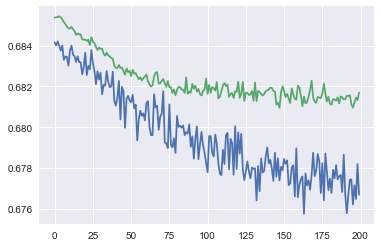

In [428]:
h = model.fit(X_train, y_train_categorical, batch_size=128, epochs=200, verbose=0,validation_data=(X_test, y_test_categorical))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

<h2>Analyze the Results</h2>

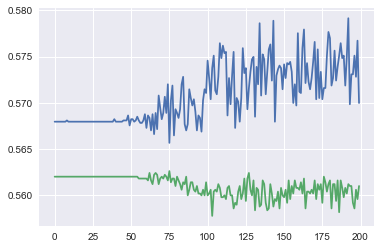

In [429]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])

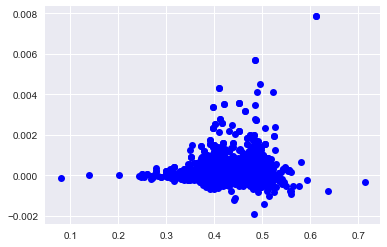

In [430]:
ynns = model.predict(X_test)
ynnsp = ynns[:,1]
plt.plot(ynnsp,y_test,'ob')

In [436]:
stats = []
xx = []
n = []
s = []
for j in range(0,100):
    a = tradeStats(y_test[ynnsp>j/100])
    s.append(a["p_win"])
    n.append(sum(ynnsp>j/100))
    xx.append(j)
n = np.array(n).reshape(-1,1)
xx = np.array(xx)


/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


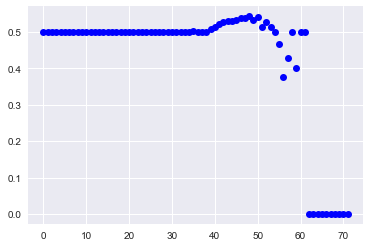

In [438]:
plt.plot(xx,s,'ob')
#plt.ylim(0,25)

<h2>Useful Functions</h2>

In [287]:
def tradeStats(results):
    
    #total profit
    total_profit = results.sum()
    number_of_trades = len(results)
    
    #probability of a win, loss or breakeven
    p_win = (results>0).sum()/len(results)
    p_loss = (results<0).sum()/len(results)
    p_be = (results==0).sum()/len(results)
    
    #Average Winner and loser
    size_win = results[results>0].sum()/ (results>0).sum()*10000
    size_loss = -results[results<0].sum()/ (results<0).sum()*10000
    rr = size_win/size_loss
    pips_without_fees = total_profit*10000
    pips_with_estimated_fees = total_profit*10000-number_of_trades*1.2
    stats = {"total_profit":total_profit,"number_of_trades":number_of_trades,"p_win":p_win,"p_loss":p_loss,"p_be":p_be,"size_win":size_win,"size_loss":size_loss,"rr":rr,"pips_without_fees":pips_without_fees,"pips_with_estimated_fees":pips_with_estimated_fees}
    return(stats)


<h2>Do Some Exploratory Analysis</h2>

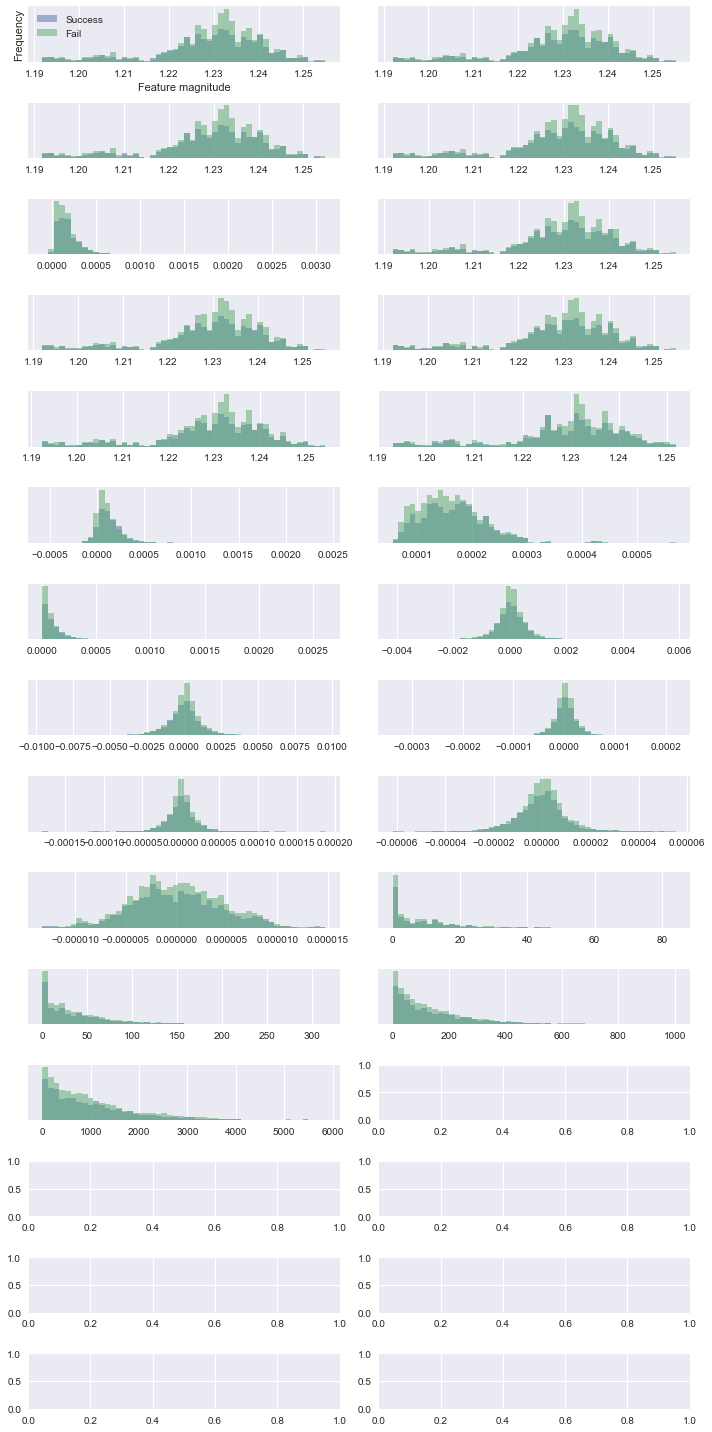

In [316]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
ax = axes.ravel()
threshold = .5e-4    
success = Xe[ye[:,0]>threshold]
failure = Xe[ye[:,0]<threshold]
for i in range(23):
    _, bins = np.histogram(X[:, i], bins=50) 
    ax[i].hist(success[:, i], bins=bins, alpha=.5) 
    ax[i].hist(failure[:, i], bins=bins, alpha=.5)
    ax[i].set_yticks(())
    ax[0].set_xlabel("Feature magnitude")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(["Success", "Fail"], loc="best")
    fig.tight_layout()

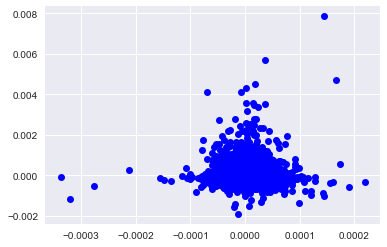

In [317]:
plt.plot(X[:,15],y,'bo')

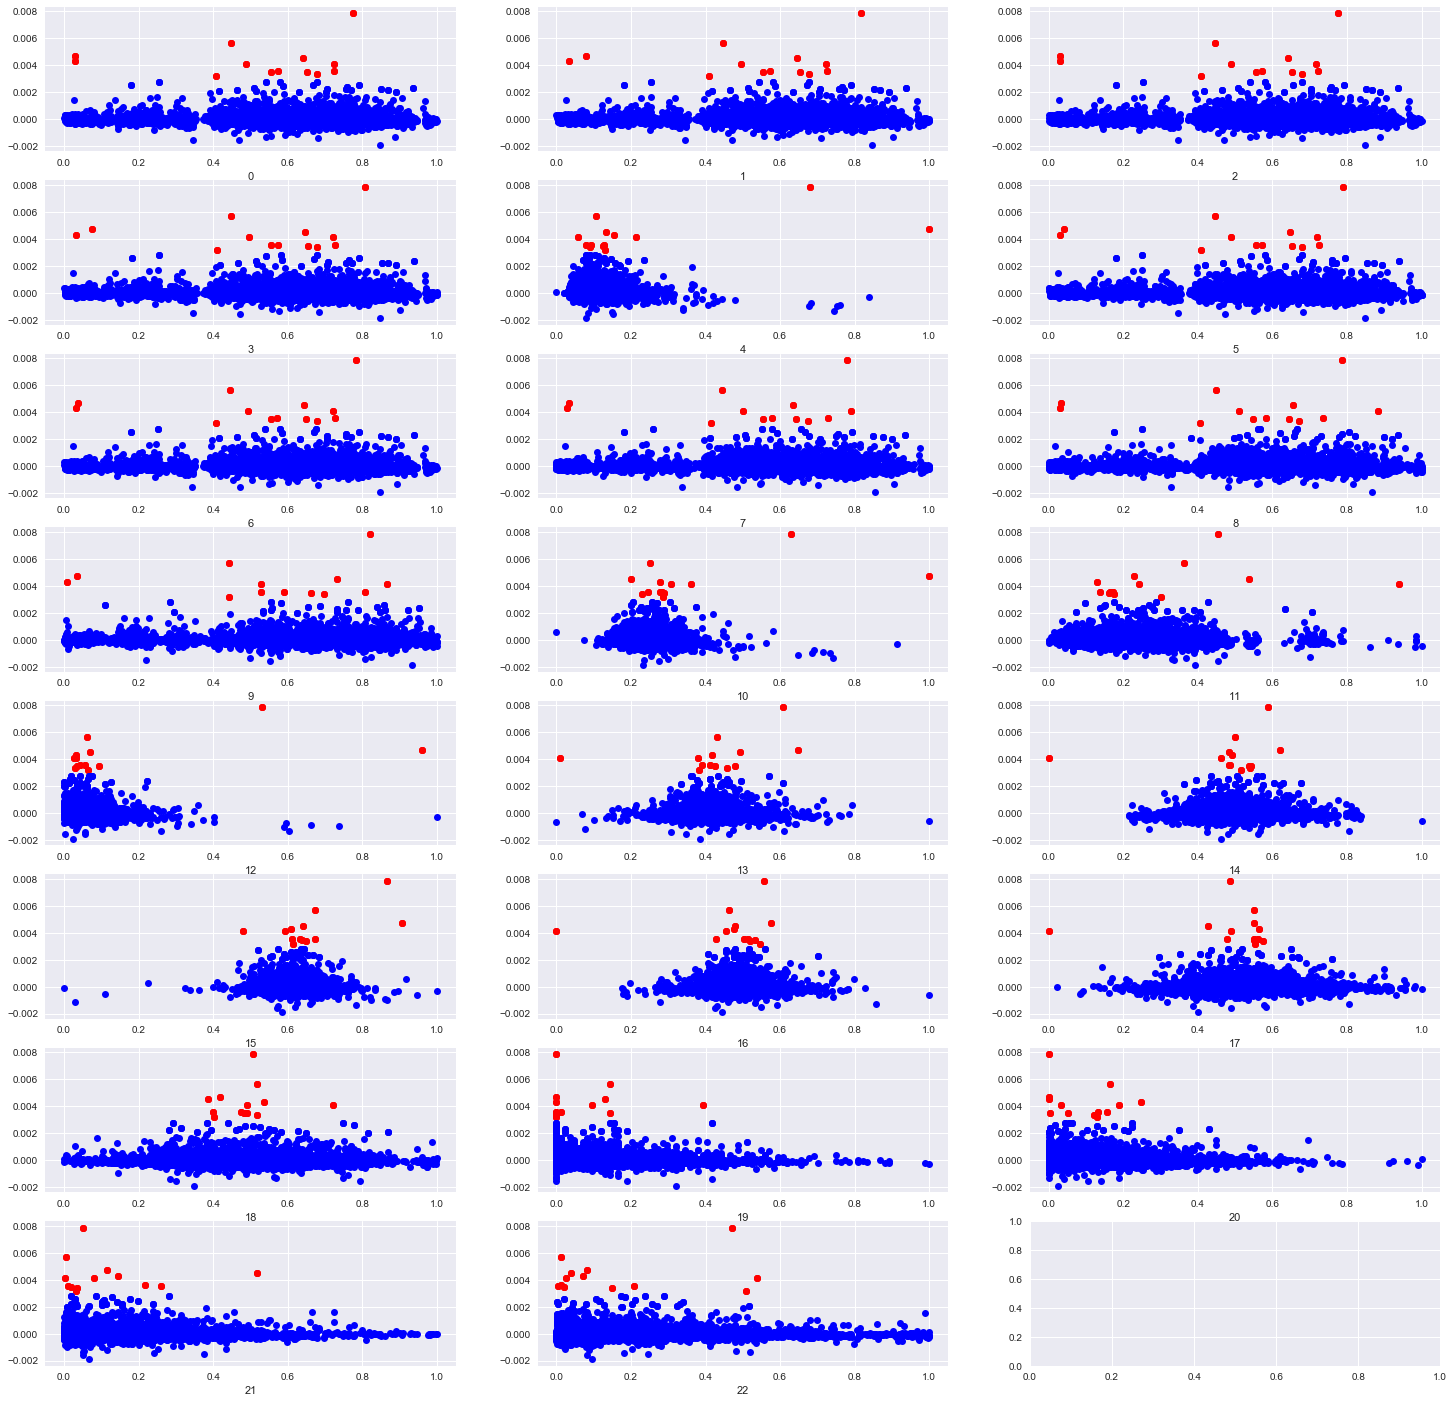

In [364]:
fig, axes = plt.subplots(8, 3, figsize=(25, 25))
ax = axes.ravel()
threshold = 3e-3    
success = Xs[ye[:,0]>threshold]
failure = Xs[ye[:,0]<threshold]
ysuccess = ye[ye[:,0]>threshold]
yfailure = ye[ye[:,0]<threshold]
for i in range(23):
    num = "{}".format(i)
    ax[i].plot(success[:,i],ysuccess,'ro')
    ax[i].plot(failure[:,i],yfailure,'bo')
    ax[i].set_xlabel(num)
    #fig.tight_layout()

In [280]:
z =  y[X[:,16]>0]

In [281]:
sum(z)/z.shape[0]

array([ -1.18812310e-05])

In [253]:
X.shape

(8789, 23)

In [310]:
X[(y[:,0]>threshold)].shape

(2299, 23)

In [308]:
y[:,0].shape

(8789,)

<h2>Try Clustering</h2>

In [373]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3)
#kmeans.fit(X)

ImportError: cannot import name 'pairwise_distances_chunked'

In [4]:
model = Sequential()
model.add(Dense(13, input_shape=(13,), activation='relu'))

In [6]:
import numpy as np
np.array([[1,2,3,4,5]]*13)

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])